In [1]:
import pandas as pd
from sklearn.preprocessing import MinMaxScaler
import numpy as np

# Load data
df = pd.read_csv('../data/processed_data.csv', parse_dates=['date'], index_col='date')

# Handle missing values
df.dropna(inplace=True)

# Normalize data (key for distance-based models)
scaler = MinMaxScaler()
df_scaled = pd.DataFrame(scaler.fit_transform(df[['Appliances', 'T_out', 'lights', 'RH_1']]),
                         columns=['Appliances', 'T_out', 'lights', 'RH_1'],
                         index=df.index)

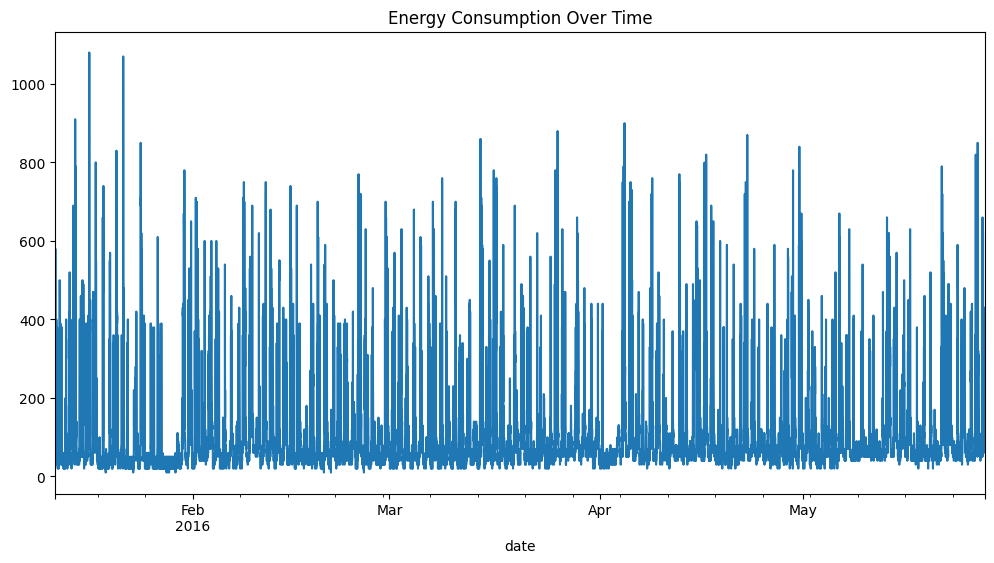

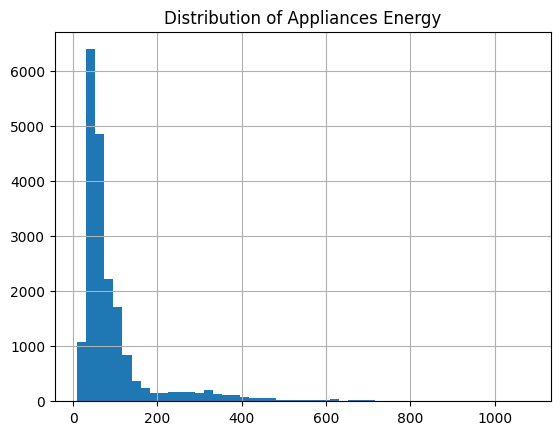

In [2]:
import matplotlib.pyplot as plt

# Plot energy consumption
df['Appliances'].plot(figsize=(12, 6), title='Energy Consumption Over Time')
plt.show()

# Check distribution
df['Appliances'].hist(bins=50)
plt.title('Distribution of Appliances Energy')
plt.show()

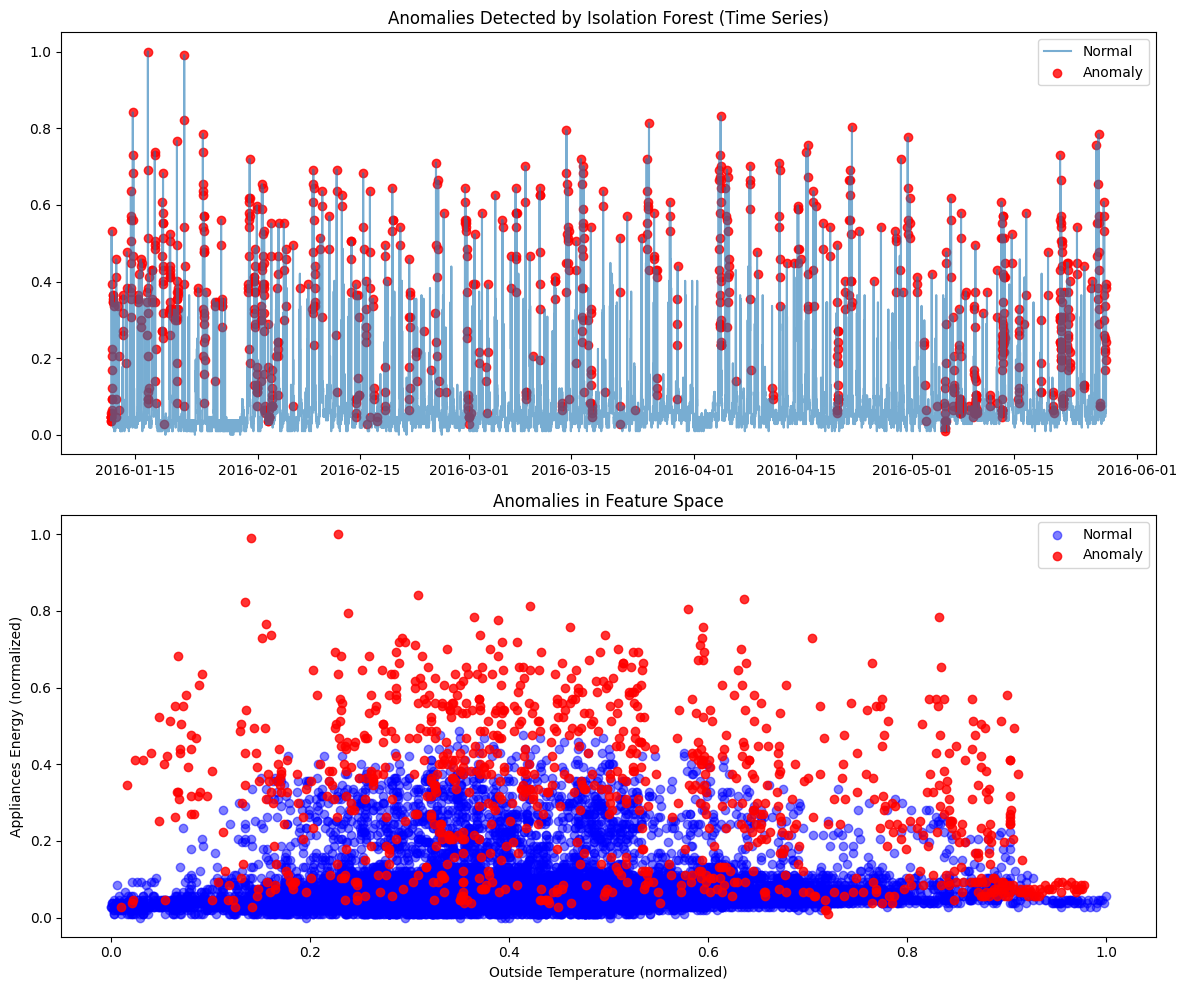

In [4]:
from sklearn.ensemble import IsolationForest

# Train model
model = IsolationForest(contamination=0.05, random_state=42)
df_scaled['anomaly'] = model.fit_predict(
    df_scaled[['Appliances', 'T_out', 'lights', 'RH_1']])  # Use all scaled features

# Visualize anomalies
fig, (ax1, ax2) = plt.subplots(2, 1, figsize=(12, 10))

# Time series plot
ax1.plot(df_scaled.index, df_scaled['Appliances'], label='Normal', alpha=0.6)
ax1.scatter(df_scaled.index[df_scaled['anomaly'] == -1],
            df_scaled['Appliances'][df_scaled['anomaly'] == -1],
            color='red', label='Anomaly', alpha=0.8)
ax1.set_title('Anomalies Detected by Isolation Forest (Time Series)')
ax1.legend()

# Scatter plot of features
ax2.scatter(df_scaled['T_out'][df_scaled['anomaly'] == 1],
            df_scaled['Appliances'][df_scaled['anomaly'] == 1],
            c='blue', label='Normal', alpha=0.5)
ax2.scatter(df_scaled['T_out'][df_scaled['anomaly'] == -1],
            df_scaled['Appliances'][df_scaled['anomaly'] == -1],
            c='red', label='Anomaly', alpha=0.8)
ax2.set_xlabel('Outside Temperature (normalized)')
ax2.set_ylabel('Appliances Energy (normalized)')
ax2.set_title('Anomalies in Feature Space')
ax2.legend()

plt.tight_layout()
plt.show()


Anomalies detected: 987 (5.00%)


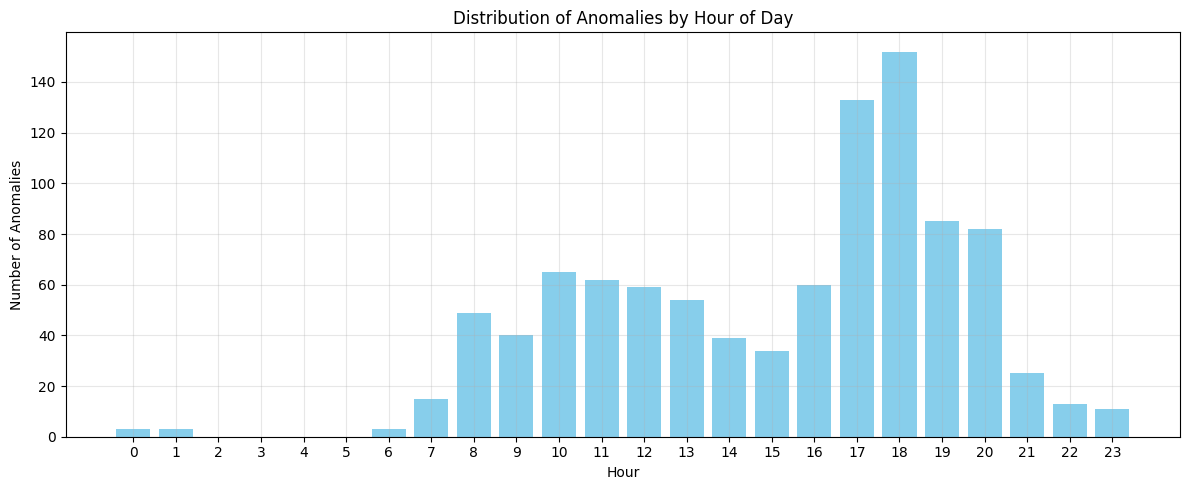


Hourly anomaly distribution:
hour
0       3
1       3
6       3
7      15
8      49
9      40
10     65
11     62
12     59
13     54
14     39
15     34
16     60
17    133
18    152
19     85
20     82
21     25
22     13
23     11
Name: count, dtype: int64


In [5]:
# Count anomalies and display percentage
anomaly_count = (df_scaled['anomaly'] == -1).sum()
print(f"Anomalies detected: {anomaly_count} ({(anomaly_count / len(df_scaled)) * 100:.2f}%)")

# Analyze anomaly segments by hour
df_scaled['hour'] = df_scaled.index.hour
anomaly_hours = df_scaled[df_scaled['anomaly'] == -1]['hour'].value_counts()

# Create visualizations
plt.figure(figsize=(12, 5))

# Bar plot of anomalies by hour
plt.bar(anomaly_hours.index, anomaly_hours.values, color='skyblue')
plt.title('Distribution of Anomalies by Hour of Day')
plt.xlabel('Hour')
plt.ylabel('Number of Anomalies')
plt.grid(True, alpha=0.3)

# Customize x-axis ticks
plt.xticks(range(24))

plt.tight_layout()
plt.show()

# Print detailed statistics
print("\nHourly anomaly distribution:")
print(anomaly_hours.sort_index())


Anomalies detected: 987 (5.00%)


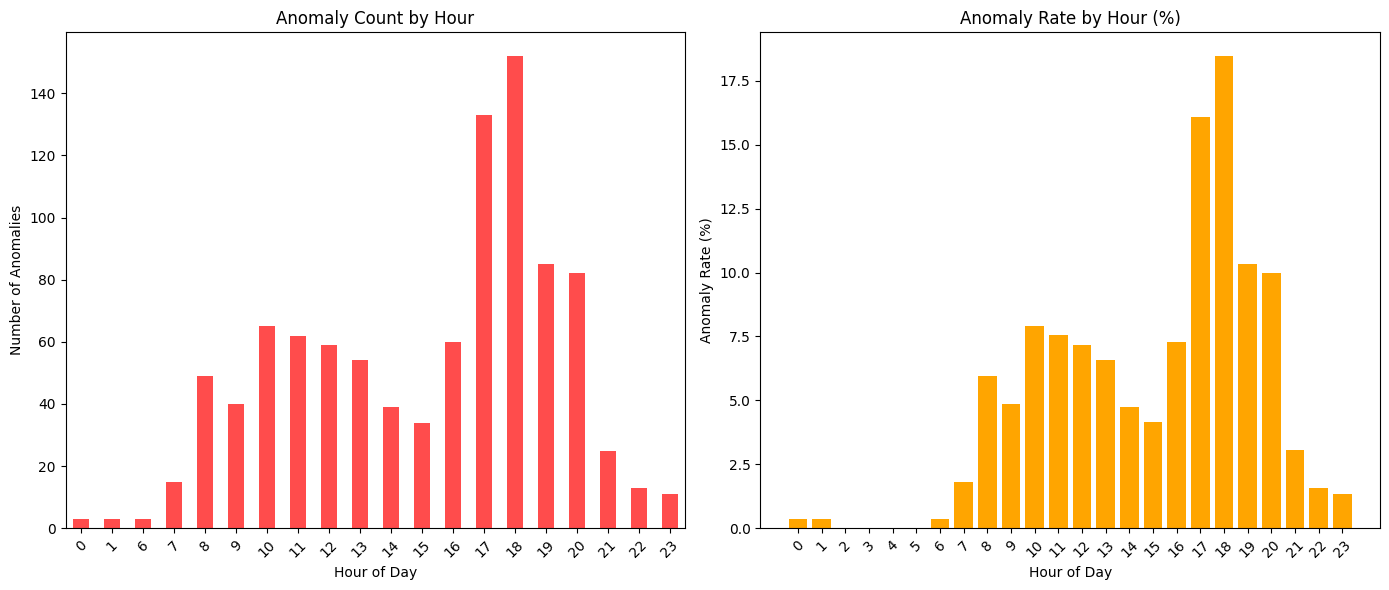

Top 5 hours with most anomalies:
hour
0     3
1     3
6     3
7    15
8    49
Name: count, dtype: int64

Top 5 hours with highest anomaly rates:
Hour 18: 18.47%
Hour 17: 16.06%
Hour 19: 10.34%
Hour 20: 9.98%
Hour 10: 7.91%


In [6]:
# Count anomalies and display percentage
anomaly_count = (df_scaled['anomaly'] == -1).sum()
anomaly_percentage = (anomaly_count / len(df_scaled)) * 100
print(f"Anomalies detected: {anomaly_count} ({anomaly_percentage:.2f}%)")

# Analyze anomaly segments by hour
df_scaled['hour'] = df_scaled.index.hour
anomaly_hours = df_scaled[df_scaled['anomaly'] == -1]['hour'].value_counts().sort_index()
normal_hours = df_scaled[df_scaled['anomaly'] == 1]['hour'].value_counts().sort_index()

# Calculate anomaly rate by hour
hourly_anomaly_rate = {}
for hour in range(24):
    total_in_hour = (df_scaled['hour'] == hour).sum()
    anomalies_in_hour = ((df_scaled['hour'] == hour) & (df_scaled['anomaly'] == -1)).sum()
    if total_in_hour > 0:
        hourly_anomaly_rate[hour] = (anomalies_in_hour / total_in_hour) * 100
    else:
        hourly_anomaly_rate[hour] = 0

# Visualize hourly patterns
plt.figure(figsize=(14, 6))

# Plot 1: Absolute count by hour
plt.subplot(1, 2, 1)
anomaly_hours.plot(kind='bar', color='red', alpha=0.7)
plt.title('Anomaly Count by Hour')
plt.xlabel('Hour of Day')
plt.ylabel('Number of Anomalies')
plt.xticks(rotation=45)

# Plot 2: Anomaly rate by hour (normalized)
plt.subplot(1, 2, 2)
plt.bar(hourly_anomaly_rate.keys(), hourly_anomaly_rate.values(), color='orange')
plt.title('Anomaly Rate by Hour (%)')
plt.xlabel('Hour of Day')
plt.ylabel('Anomaly Rate (%)')
plt.xticks(range(24), rotation=45)
plt.tight_layout()
plt.show()

# Print detailed summary
print("Top 5 hours with most anomalies:")
print(anomaly_hours.head(5))
print("\nTop 5 hours with highest anomaly rates:")
sorted_rates = {k: v for k, v in sorted(hourly_anomaly_rate.items(), key=lambda item: item[1], reverse=True)}
for hour, rate in list(sorted_rates.items())[:5]:
    print(f"Hour {hour}: {rate:.2f}%")

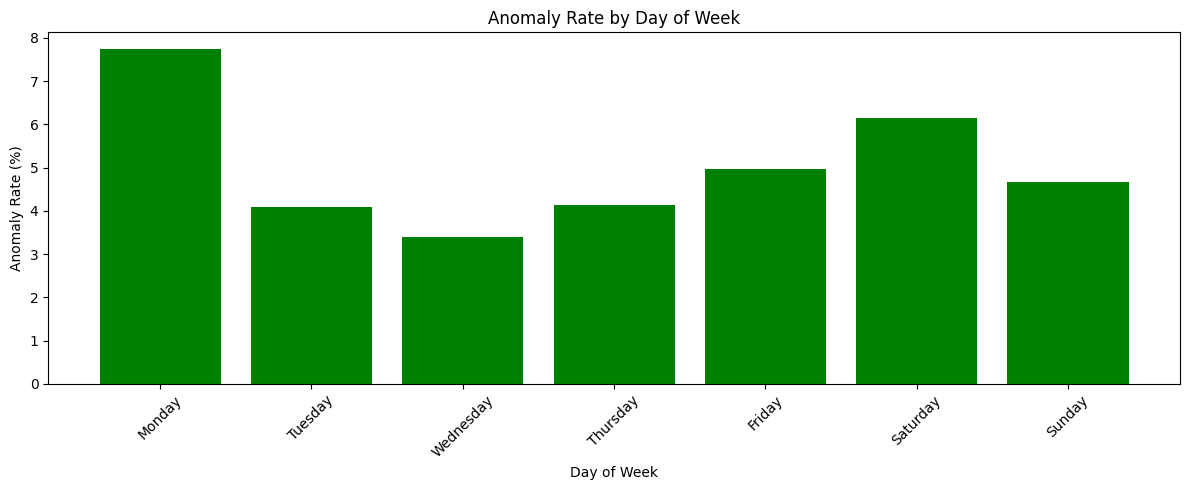

In [7]:
# Add day of week analysis
df_scaled['day_of_week'] = df_scaled.index.dayofweek
days = ['Monday', 'Tuesday', 'Wednesday', 'Thursday', 'Friday', 'Saturday', 'Sunday']
anomaly_days = df_scaled[df_scaled['anomaly'] == -1]['day_of_week'].value_counts().sort_index()

# Calculate anomaly rate by day
daily_anomaly_rate = {}
for day in range(7):
    total_in_day = (df_scaled['day_of_week'] == day).sum()
    anomalies_in_day = ((df_scaled['day_of_week'] == day) & (df_scaled['anomaly'] == -1)).sum()
    if total_in_day > 0:
        daily_anomaly_rate[days[day]] = (anomalies_in_day / total_in_day) * 100
    else:
        daily_anomaly_rate[days[day]] = 0

# Visualize daily patterns
plt.figure(figsize=(12, 5))
plt.bar(daily_anomaly_rate.keys(), daily_anomaly_rate.values(), color='green')
plt.title('Anomaly Rate by Day of Week')
plt.xlabel('Day of Week')
plt.ylabel('Anomaly Rate (%)')
plt.xticks(rotation=45)
plt.tight_layout()
plt.show()

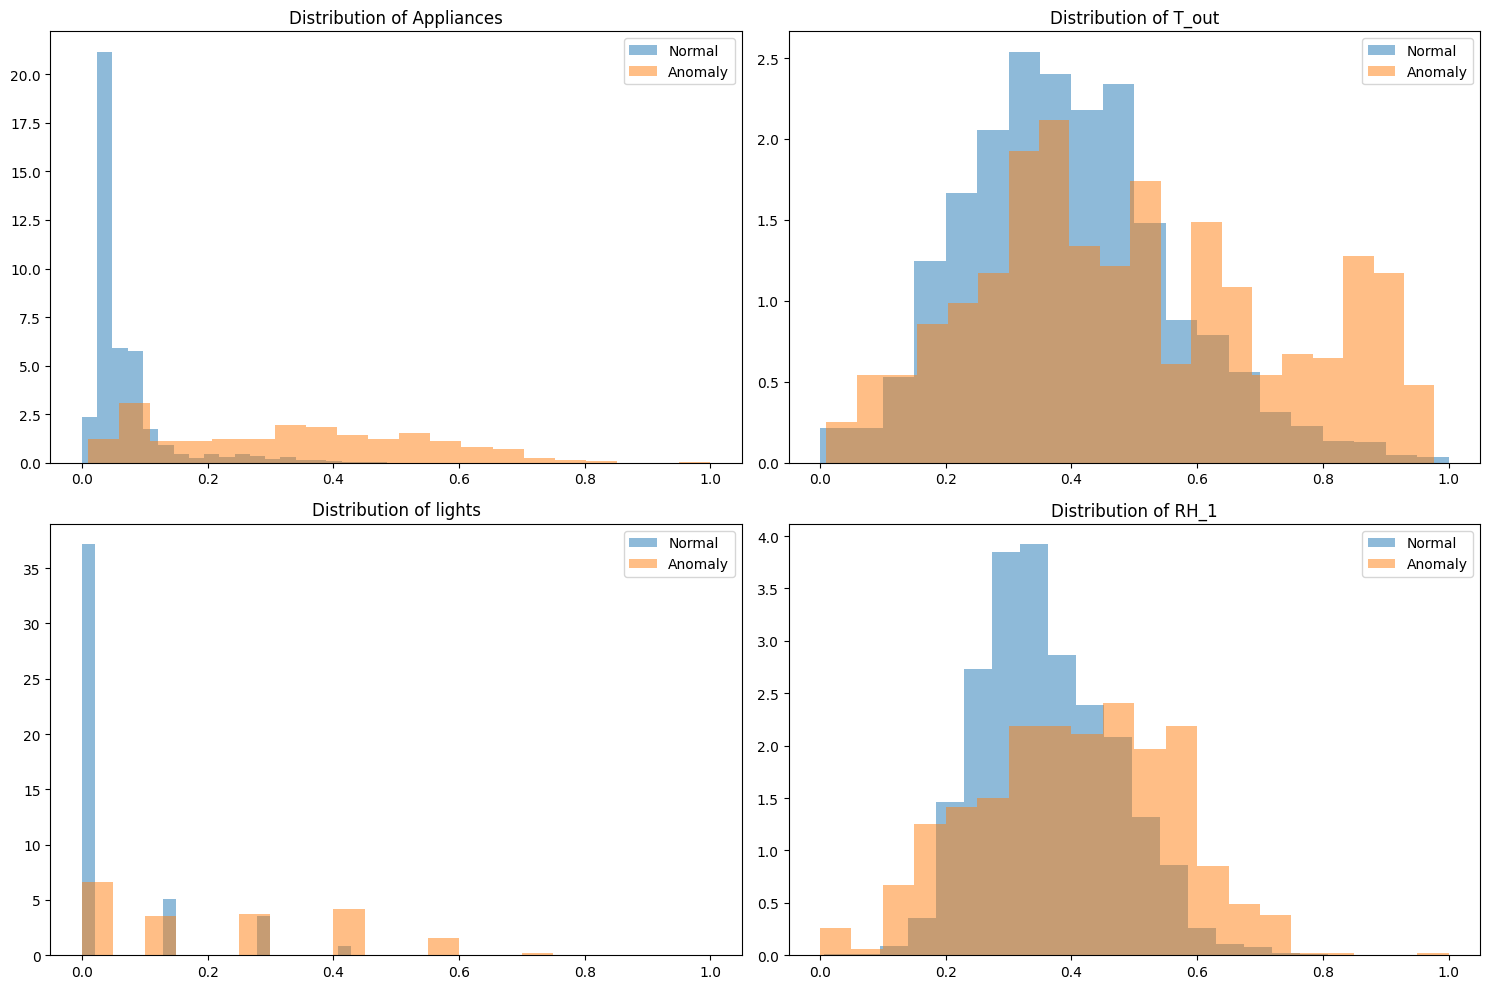

Mean values for Normal vs Anomaly points:
              Normal   Anomaly  Difference %
Appliances  0.068786  0.332159    382.888457
T_out       0.393886  0.497908     26.409091
lights      0.045452  0.222608    389.760414
RH_1        0.362122  0.405092     11.866018


In [9]:
# Look for correlations with environmental variables
feature_cols = ['Appliances', 'T_out', 'lights', 'RH_1']
df_anomalies = df_scaled[df_scaled['anomaly'] == -1][feature_cols]
df_normal = df_scaled[df_scaled['anomaly'] == 1][feature_cols]

# Compare the distribution of features for normal vs. anomaly points
plt.figure(figsize=(15, 10))
for i, feature in enumerate(feature_cols):
    plt.subplot(2, 2, i + 1)
    plt.hist(df_normal[feature], bins=20, alpha=0.5, label='Normal', density=True)
    plt.hist(df_anomalies[feature], bins=20, alpha=0.5, label='Anomaly', density=True)
    plt.title(f'Distribution of {feature}')
    plt.legend()
plt.tight_layout()
plt.show()

# Calculate and print mean values for comparison
print("Mean values for Normal vs Anomaly points:")
normal_means = df_normal.mean()
anomaly_means = df_anomalies.mean()
comparison = pd.DataFrame({'Normal': normal_means, 'Anomaly': anomaly_means,
                           'Difference %': ((anomaly_means - normal_means) / normal_means * 100)})
print(comparison)

In [10]:
anomaly_details = df_scaled[df_scaled['anomaly'] == -1].copy()
anomaly_details['timestamp'] = anomaly_details.index
anomaly_details.to_csv('../data/anomaly_details.csv', index=False)
print(f"Saved detailed anomaly information to '../data/anomaly_details.csv'")


Saved detailed anomaly information to '../data/anomaly_details.csv'


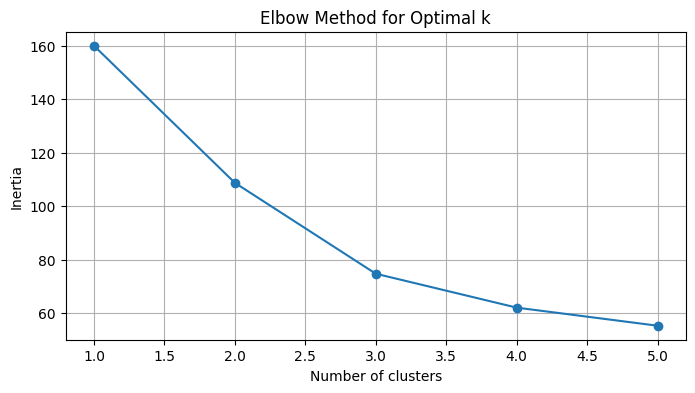


Cluster 0 Statistics:
       Appliances       T_out      lights        RH_1
count  307.000000  307.000000  307.000000  307.000000
mean     0.237876    0.789535    0.091205    0.413343
std      0.157969    0.110756    0.125156    0.203424
min      0.009346    0.580922    0.000000    0.000000
25%      0.084112    0.678992    0.000000    0.241698
50%      0.233645    0.815648    0.000000    0.433905
75%      0.355140    0.882101    0.142857    0.585772
max      0.785047    0.977492    0.428571    0.744886

Cluster 1 Statistics:
       Appliances       T_out      lights        RH_1
count  382.000000  382.000000  382.000000  382.000000
mean     0.519083    0.363839    0.141361    0.382570
std      0.125368    0.151154    0.132136    0.121818
min      0.252336    0.016077    0.000000    0.048895
25%      0.420561    0.264068    0.000000    0.295867
50%      0.514019    0.371651    0.142857    0.379873
75%      0.607477    0.478832    0.285714    0.473168
max      1.000000    0.704180    0.4

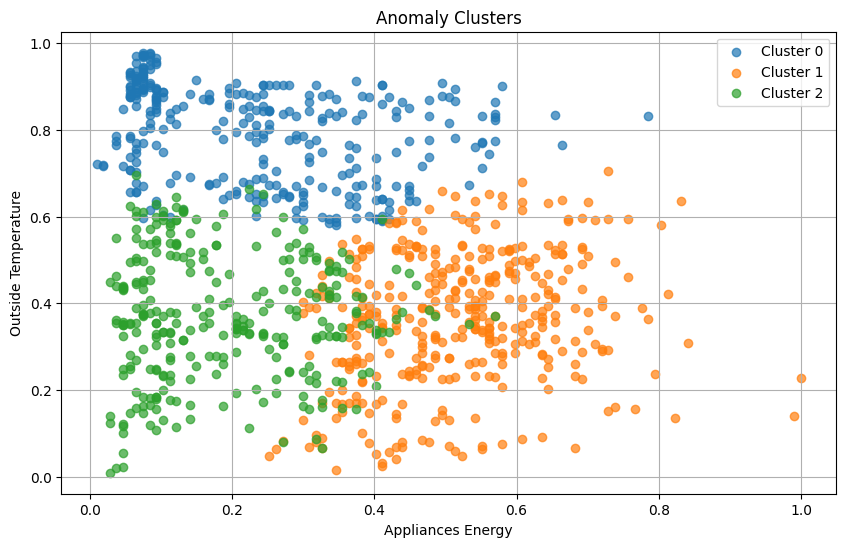

In [11]:
from sklearn.cluster import KMeans

# Extract features for anomalies only
anomaly_features = df_scaled[df_scaled['anomaly'] == -1][feature_cols]

if len(anomaly_features) > 5:  # Only if we have enough anomalies
    # Find the optimal number of clusters using the elbow method
    inertia = []
    k_range = range(1, min(6, len(anomaly_features)))
    for k in k_range:
        kmeans = KMeans(n_clusters=k, random_state=42)
        kmeans.fit(anomaly_features)
        inertia.append(kmeans.inertia_)

    # Plot elbow curve
    plt.figure(figsize=(8, 4))
    plt.plot(k_range, inertia, 'o-')
    plt.xlabel('Number of clusters')
    plt.ylabel('Inertia')
    plt.title('Elbow Method for Optimal k')
    plt.grid(True)
    plt.show()

    # Choose optimal k (this is simplified - you'd normally inspect the plot)
    optimal_k = 3  # Example - you'd choose based on the elbow curve

    # Apply K-means clustering
    kmeans = KMeans(n_clusters=optimal_k, random_state=42)
    anomaly_features['cluster'] = kmeans.fit_predict(anomaly_features)

    # Analyze clusters
    for cluster in range(optimal_k):
        print(f"\nCluster {cluster} Statistics:")
        print(anomaly_features[anomaly_features['cluster'] == cluster][feature_cols].describe())

    # Visualize the clusters
    plt.figure(figsize=(10, 6))
    for cluster in range(optimal_k):
        cluster_data = anomaly_features[anomaly_features['cluster'] == cluster]
        plt.scatter(cluster_data['Appliances'], cluster_data['T_out'],
                    label=f'Cluster {cluster}', alpha=0.7)

    plt.title('Anomaly Clusters')
    plt.xlabel('Appliances Energy')
    plt.ylabel('Outside Temperature')
    plt.legend()
    plt.grid(True)
    plt.show()